In [1]:
import numpy as np
# 系统参数
A = np.array([[0,1,0],
              [1,-2,0],
              [0,-1,-1]])
B = np.array([[0,0],
              [1,0],
              [0,1]])#跟书上一样的#[[1,0],[0,0],[0,1]]
C = np.array([[1,0,0],
              [0,1,0],
              [0,0,1]])
Bd = np.array([[0.1,0,0,0,0,0],
               [0,0.1,0,0,0,0],
               [0,0,0.1,0,0,0]])
Dd = np.array([[0,0,0,0.01,0,0],
              [0,0,0,0,0.01,0],
              [0,0,0,0,0,0.01]])

C1 = C[[0],:]
C2 = C[[1],:]
C3 = C[[2],:]
Dd1 = Dd[[0],:]
Dd2 = Dd[[1],:]
Dd3 = Dd[[2],:]

nx = A.shape[0]
nu = B.shape[1]
ny = C.shape[0]
nd = Bd.shape[1]

In [2]:
from scipy.linalg import expm
import cvxpy as cp
# 观测器设计
P = cp.Variable((nx,nx), symmetric=True)
W = cp.Variable((nx,1))
constraints = [(P@A - W@C1.reshape(-1,1).T) + (P@A - W@C1.reshape(-1,1).T).T << -0.001*np.eye(3),P >>0.001*np.eye(3)]
prob = cp.Problem(cp.Minimize(0),constraints)
prob.solve()
P_value = P.value
W_value = W.value
L1 = np.linalg.pinv(P_value)@W_value

P = cp.Variable((nx,nx),symmetric=True)
W = cp.Variable((nx,1))
constraints = [(P@A - W@C2.reshape(-1,1).T) + (P@A - W@C2.reshape(-1,1).T).T << -0.001*np.eye(3),P >>0.001*np.eye(3)]
prob = cp.Problem(cp.Minimize(0),constraints)
prob.solve()
P_value = P.value
W_value = W.value
L2 = np.linalg.pinv(P_value)@W_value

P = cp.Variable((nx,nx), symmetric=True)
W = cp.Variable((nx,1))
constraints = [(P@A - W@C3.reshape(-1,1).T) + (P@A - W@C3.reshape(-1,1).T).T << -0.001*np.eye(3),P >>0.001*np.eye(3)]
prob = cp.Problem(cp.Minimize(0),constraints)
prob.solve()
P_value = P.value
W_value = W.value
L3 = np.linalg.pinv(P_value)@W_value
print(L1,L2,L3)

[[0.4187567 ]
 [1.95801449]
 [0.02936123]] [[ 2.335581  ]
 [-1.18699604]
 [-0.99998576]] [[-6.41921431]
 [-5.08331917]
 [ 1.33053828]]


In [3]:
# 数值仿真
dt =0.05
td = 20
tspan = np.arange(0,td,dt)
Nk = len(tspan)

In [4]:
# 被诊断对象的相关变量
x = np.zeros((nx,Nk))
u = np.zeros((nu,Nk))
y = np.zeros((ny,Nk))
d = np.zeros((nd,Nk))
f = np.zeros(Nk)
# 残差生成器相关变量
xhat1 = np.zeros((nx,Nk))
xhat2 = np.zeros((nx,Nk))
xhat3 = np.zeros((nx,Nk))
r1 = np.zeros((Nk,1))
r2 = np.zeros((Nk,1))
r3 = np.zeros((Nk,1))
# 阈值和残差计算相关参数
e0_up = np.array([[0.01],[0.01],[0.01]])
e0_low = -e0_up
d_up = np.ones((nd,1))
d_low = -d_up

C1p = np.maximum(C1,0)
C1m = C1p - C1
Dd1p = np.maximum(Dd1,0)
Dd1m = Dd1p - Dd1

C2p = np.maximum(C2,0)
C2m = C2p - C2
Dd2p = np.maximum(Dd2,0)
Dd2m = Dd2p - Dd2

C3p = np.maximum(C3,0)
C3m = C3p - C3
Dd3p = np.maximum(Dd3,0)
Dd3m = Dd3p - Dd3

z1_up = np.zeros((Nk,1))
z1_low = np.zeros((Nk,1))
z2_up = np.zeros((Nk,1))
z2_low = np.zeros((Nk,1))
z3_up = np.zeros((Nk,1))
z3_low = np.zeros((Nk,1))
r1_up = np.zeros((Nk,1))
r1_low = np.zeros((Nk,1))
r2_up = np.zeros((Nk,1))
r2_low = np.zeros((Nk,1))
r3_up = np.zeros((Nk,1))
r3_low = np.zeros((Nk,1))
FD_result = np.zeros((3,Nk))
FI_result = np.zeros(Nk)

In [5]:
x[:,[0]] = (0.01*(2*np.random.rand(nx) -1)).reshape(-1,1) 
y[:,[0]] = C@x[:,[0]] + Dd@d[:,[0]]

r1[[0],:] = y[[0],[0]] - C1@xhat1[:,[0]]
r2[[0],:] = y[[1],[0]] - C2@xhat2[:,[0]]
r3[[0],:] = y[[2],[0]] - C3@xhat3[:,[0]]

Phi1 = C1
Phi1p = np.maximum(Phi1,0)
Phi1m = Phi1p - Phi1
r1_up[[0],:] = Phi1p@e0_up - Phi1m@e0_low + Dd1p@d_up - Dd1m@d_low
r1_low[[0],:] = Phi1p@e0_low - Phi1m@e0_up + Dd1p@d_low - Dd1m@d_up

Phi2 = C2
Phi2p = np.maximum(Phi2,0)
Phi2m = Phi2p - Phi2
r2_up[[0],:] = Phi2p@e0_up - Phi2m@e0_low + Dd2p@d_up - Dd2m@d_low
r2_low[[0],:] = Phi2p@e0_low - Phi2m@e0_up + Dd2p@d_low - Dd2m@d_up

Phi3 = C3
Phi3p = np.maximum(Phi3,0)
Phi3m = Phi3p - Phi3
r3_up[[0],:] = Phi3p@e0_up - Phi3m@e0_low + Dd3p@d_up - Dd3m@d_low
r3_low[[0],:] = Phi3p@e0_low - Phi3m@e0_up + Dd3p@d_low - Dd3m@d_up

In [6]:
for k in range(1,Nk):
    t = k*dt
    if k*dt <= 5:
        f = 0
    else:
        f = 1
    
    F = np.array([[0],[1],[0]])
    
    d[:,[k]] = (2*np.random.rand(nd) -1).reshape(-1,1) 
    dx = A@x[:,[k-1]] + Bd@d[:,[k-1]]
    x[:,[k]] = x[:,[k-1]] + dx*dt
    y[:,[k]] = C@x[:,[k]] + F*f + Dd@d[:,[k]]
    
    # 残差生成
    dxhat1 = A@xhat1[:,[k-1]] + B@u[:,[k-1]] + L1@(y[0,k-1] - C1@xhat1[:,[k-1]])
    xhat1[:,[k]] = xhat1[:,[k-1]] + dxhat1*dt
    dxhat2 = A@xhat2[:,[k-1]] + B@u[:,[k-1]] + L2@(y[1,k-1] - C2@xhat2[:,[k-1]])
    xhat2[:,[k]] = xhat2[:,[k-1]] + dxhat2*dt
    dxhat3 = A@xhat3[:,[k-1]] + B@u[:,[k-1]] + L3@(y[2,k-1] - C3@xhat3[:,[k-1]])
    xhat3[:,[k]] = xhat3[:,[k-1]] + dxhat3*dt
    
    r1[[k],:] = y[[0],[k]] - C1@xhat1[:,[k]]
    r2[[k],:] = y[[1],[k]] - C2@xhat2[:,[k]]
    r3[[k],:] = y[[2],[k]] - C3@xhat3[:,[k]]

    # 阈值计算1
    Phi1 = C1@expm((A - L1@C1.reshape(-1,1).T)*(k-1)*dt)
    Phi1p = np.maximum(Phi1,0)
    Phi1m = Phi1p - Phi1
    PH1 = Phi1@(Bd - L1@Dd1.reshape(-1,1).T)
    PH1p = np.maximum(PH1,0)
    PH1m = PH1p - PH1
    dz1_up = PH1p@d_up - PH1m@d_low
    dz1_low = PH1p@d_low - PH1m@d_up
    z1_up[[k],:] = dz1_up*dt + z1_up[k-1]
    z1_low[[k],:] = dz1_low*dt + z1_low[k-1]

    r1_up[[k],:] = Phi1p@e0_up - Phi1m@e0_low + z1_up[k] + Dd1p@d_up - Dd1m@d_low
    r1_low[[k],:] = Phi1p@e0_low - Phi1m@e0_up + z1_low[k] + Dd1p@d_low - Dd1m@d_up

    # 阈值计算2
    Phi2 = C2@expm((A - L2@C2.reshape(-1,1).T)*(k-1)*dt)
    Phi2p = np.maximum(Phi2,0)
    Phi2m = Phi2p - Phi2
    PH2 = Phi2@(Bd - L2@Dd2.reshape(-1,1).T)
    PH2p = np.maximum(PH2,0)
    PH2m = PH2p - PH2
    dz2_up = PH2p@d_up - PH2m@d_low
    dz2_low = PH2p@d_low - PH2m@d_up
    z2_up[[k],:] = dz2_up*dt + z2_up[k-1]
    z2_low[[k],:] = dz2_low*dt + z2_low[k-1]

    r2_up[[k],:] = Phi2p@e0_up - Phi2m@e0_low + z2_up[k] + Dd2p@d_up - Dd2m@d_low
    r2_low[[k],:] = Phi2p@e0_low - Phi2m@e0_up + z2_low[k] + Dd2p@d_low - Dd2m@d_up

    # 阈值计算3
    Phi3 = C3@expm((A - L3@C3.reshape(-1,1).T)*(k-1)*dt)
    Phi3p = np.maximum(Phi3,0)
    Phi3m = Phi3p - Phi3
    PH3 = Phi3@(Bd - L3@Dd3.reshape(-1,1).T)
    PH3p = np.maximum(PH3,0)
    PH3m = PH3p - PH3
    dz3_up = PH3p@d_up - PH3m@d_low
    dz3_low = PH3p@d_low - PH3m@d_up
    z3_up[[k],:] = dz3_up*dt + z3_up[k-1]
    z3_low[[k],:] = dz3_low*dt + z3_low[k-1]

    r3_up[[k],:] = Phi3p@e0_up - Phi3m@e0_low + z3_up[k] + Dd3p@d_up - Dd3m@d_low
    r3_low[[k],:] = Phi3p@e0_low - Phi3m@e0_up + z3_low[k] + Dd3p@d_low - Dd3m@d_up

    # 故障检测与分离
    FD_result[[0],[k]] =0 if r1[[k],:] <= r1_up[[k],:] and r1[[k],:] >= r1_low[[k],:] else 1
    FD_result[[1],[k]] =0 if r2[[k],:] <= r2_up[[k],:] and r2[[k],:] >= r2_low[[k],:] else 1
    FD_result[[2],[k]] =0 if r3[[k],:] <= r3_up[[k],:] and r3[[k],:] >= r3_low[[k],:] else 1

    FI_result[k] =0 if sum(FD_result[:,[k]]) <0.5 else np.argmax(FD_result[:,[k]]) + 1

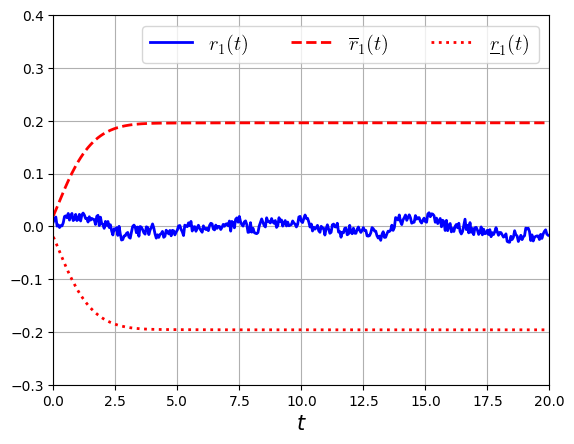

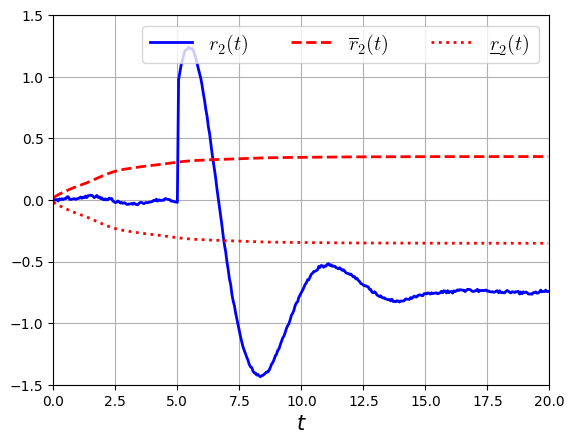

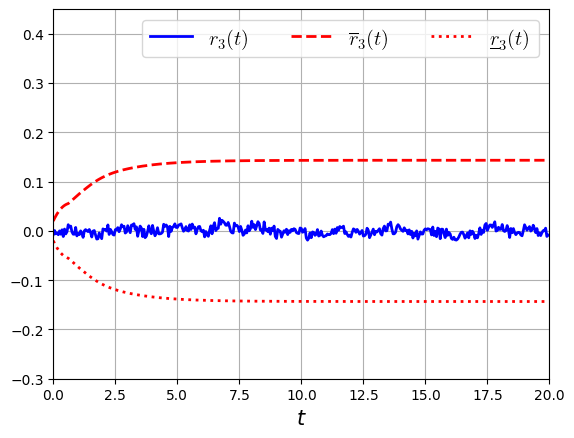

In [7]:
import matplotlib.pyplot as plt
# 绘图
plt.figure() #figsize=(20/2.54, 10/2.54)
plt.plot(tspan,r1,'b',linewidth=2)
plt.plot(tspan,r1_up,'r--',linewidth=2)
plt.plot(tspan,r1_low,'r:',linewidth=2)
plt.rc('text', usetex=True)
plt.legend([r'$r_1(t)$',r'$\overline{r}_1(t)$',r'$\underline{r}_1(t)$'],loc='best',ncol=3,fontsize=15)
plt.rc('text', usetex=False)
plt.xlabel(r'$t$',fontsize=15)
plt.axis([0, td, -0.3, 0.4])
plt.grid()
plt.savefig('Fig7-3.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(tspan,r2,'b',linewidth=2)
plt.plot(tspan,r2_up,'r--',linewidth=2)
plt.plot(tspan,r2_low,'r:',linewidth=2)
plt.rc('text', usetex=True)
plt.legend([r'$r_2(t)$',r'$\overline{r}_2(t)$',r'$\underline{r}_2(t)$'],loc='best',ncol=3,fontsize=15)
plt.rc('text', usetex=False)
plt.xlabel(r'$t$',fontsize=15)
plt.grid()
plt.axis([0, td, -1.5, 1.5])
plt.savefig('Fig7-4.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(tspan,r3,'b',linewidth=2)
plt.plot(tspan,r3_up,'r--',linewidth=2)
plt.plot(tspan,r3_low,'r:',linewidth=2)
plt.rc('text', usetex=True)
plt.legend([r'$r_3(t)$',r'$\overline{r}_3(t)$',r'$\underline{r}_3(t)$'],loc='best',ncol=3,fontsize=15)
plt.rc('text', usetex=False)
plt.xlabel(r'$t$',fontsize=15)
plt.axis([0, td, -0.3, 0.45])
plt.grid()
plt.savefig('Fig7-5.png', dpi=300, bbox_inches='tight')
plt.show()
